In [1]:
from pathlib import Path
from IPython.display import HTML, display
css = Path("../../../css/custom.css").read_text(encoding="utf-8")
display(HTML(f"<style>{css}</style>"))

# Chapter 1 — Introduction to Machine Learning  
## Lesson 11: What “Good Performance” Means (Generalization, Robustness, Reliability)

In machine learning, “performance” is not a single number. A model can look excellent on a benchmark and still be unsafe, brittle, or misleading in production.

In practice, teams evaluate performance along **three complementary axes**:

- **Generalization**: how well the model performs on *unseen* data from the deployment population.
- **Robustness**: how stable performance remains under realistic stress (noise, outliers, missing values, distribution shift).
- **Reliability**: whether predicted probabilities, uncertainty, and reported metrics are trustworthy and reproducible.

This lesson gives you a rigorous, practitioner-grade framework for answering a real deployment question:

> “Is this model good enough to ship?”

You will see why “high accuracy” (or “low error”) is necessary but often not sufficient, and you will learn how to design evaluation protocols that are difficult to game and easy to defend.

### Learning objectives

By the end of this lesson, you will be able to:

1. Explain **why training performance is not the goal**, and quantify the **generalization gap**.
2. Choose evaluation protocols that match the data-generating process: random splits, stratification, group splits, and time-based splits.
3. Design **robustness stress tests** (noise, missingness, outliers, mild distribution shift) and interpret failure modes.
4. Assess **reliability** via probability calibration, threshold tradeoffs, metric uncertainty, and stability across reruns.
5. Write a concise **evaluation memo** that communicates assumptions, limitations, risk, and monitoring hooks.

---

### The evaluation contract (a professional mental model)

A model is “good” relative to an **evaluation contract**—a specification of what you are promising.

- **Population**: who/what is the model for?
- **Time**: which time window; what drift is expected?
- **Action**: what decision will the model drive?
- **Costs**: which errors matter most?
- **Constraints**: latency, interpretability, data availability, compliance.
- **Monitoring**: what signals will detect failure after deployment?

```mermaid
flowchart TD
A[Deployment distribution] --> B[Training sample]
A --> C[Future / held-out sample]
B --> D[Fit model]
D --> E[Predictions]
C --> E
E --> F[Metrics + uncertainty + diagnostics]
F --> G{Ship?}
G -->|Generalization| H[Out-of-sample performance]
G -->|Robustness| I[Stress / shift behavior]
G -->|Reliability| J[Calibration + stability]
```

Note: Mermaid diagrams may not render in some notebook viewers. The evaluation logic still applies.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, HuberRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.calibration import calibration_curve

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    mean_squared_error, mean_absolute_error,
    brier_score_loss, log_loss
)

RANDOM_STATE = 7
np.random.seed(RANDOM_STATE)

print("Random seed:", RANDOM_STATE)
print("Current working dir:", Path.cwd())

# Repo-relative dataset paths (as you requested)
PATH_DIAB = Path("../../../Datasets/Classification/diabetes.csv")
PATH_IRIS = Path("../../../Datasets/Classification/iris.csv")
PATH_WINE = Path("../../../Datasets/Classification/Wine_Quality.csv")
PATH_HOUSE = Path("../../../Datasets/Regression/house-prices.csv")
PATH_AIRPORTS = Path("../../../Datasets/Clustering/airports.csv")

Random seed: 7
Current working dir: C:\Users\LENOVO.PIESC\Desktop\Machine_Learning_Tutorials\Tutorials\English\Chapter1


## 1. Generalization: performance on *unseen* data

A supervised learning algorithm fits a function $f$ that maps inputs $X$ to outputs $y$.  
“Good performance” means: **low expected loss on the deployment distribution**, not low loss on the training set.

### 1.1 Risk vs empirical risk

Let $\ell(\hat{y}, y)$ be a loss function (e.g., squared error, log loss). Then:

- **Population (true) risk**:
  $$R(f) = \mathbb{E}_{(X,y)\sim \mathcal{D}}\left[\ell(f(X), y)\right]$$

- **Empirical (training) risk** on dataset $\{(x_i,y_i)\}_{i=1}^n$:
  $$\hat{R}_n(f) = \frac{1}{n}\sum_{i=1}^{n}\ell(f(x_i), y_i)$$

The core difficulty of ML is that $R(f)$ is defined on the **unknown distribution** $\mathcal{D}$.  
We do not observe $\mathcal{D}$ directly, so we must estimate out-of-sample performance using evaluation data and protocols.

### 1.2 The generalization gap

A useful diagnostic is the **generalization gap**:

$$\text{gap} \approx \hat{R}_{\text{test}}(f) - \hat{R}_{\text{train}}(f)$$

- If the gap is large and test risk is worse, the model likely **overfits**.
- If both train and test risk are poor, the model likely **underfits** or the features are not informative.
- If both are strong and stable, the model is a candidate—subject to robustness and reliability checks.

### 1.3 Bias–variance intuition (why “good” is not “complex”)

Conceptually:

- **Bias**: error due to wrong assumptions or too-simple models.
- **Variance**: sensitivity to the particular training sample (overfitting risk).
- **Noise**: irreducible uncertainty in the labels.

A “good” model balances bias and variance for the **deployment setting**.

### 1.4 A practical rule

Never accept a model based on training score. Require at least one of:

- a **held-out test set** with correct split hygiene, or
- **cross-validation** with correct leakage prevention, or
- a **time-/group-aware** evaluation if the deployment setting demands it.

In [3]:
# Example 1: Generalization gap via polynomial regression (synthetic)

import math
import warnings

# Some polynomial design matrices can become ill-conditioned at high degrees.
# We mitigate this by:
#   1) scaling polynomial features, and
#   2) using stronger ridge regularization.
# This keeps the demo stable across OS / BLAS backends / Python versions.

try:
    from scipy.linalg import LinAlgWarning
    warnings.filterwarnings("ignore", category=LinAlgWarning)
except Exception:
    pass

rng = np.random.default_rng(RANDOM_STATE)

n = 350
X = rng.uniform(-3, 3, size=(n, 1))
y = np.sin(X[:, 0]) + 0.25 * rng.normal(size=n)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.35, random_state=RANDOM_STATE
)

degrees = list(range(1, 16))
rows = []

for d in degrees:
    model = Pipeline([
        ("poly", PolynomialFeatures(degree=d, include_bias=False)),
        ("scaler", StandardScaler()),
        ("ridge", Ridge(alpha=1.0, solver="svd"))
    ])
    model.fit(X_train, y_train)
    pred_tr = model.predict(X_train)
    pred_te = model.predict(X_test)

    rmse_tr = math.sqrt(mean_squared_error(y_train, pred_tr))
    rmse_te = math.sqrt(mean_squared_error(y_test, pred_te))

    rows.append((d, rmse_tr, rmse_te, rmse_te - rmse_tr))

results_poly = pd.DataFrame(rows, columns=["degree", "rmse_train", "rmse_test", "gap(test-train)"])
results_poly.head(10)


,degree,rmse_train,rmse_test,gap(test-train)
0,1,0.466667,0.451245,-0.015422
1,2,0.465980,0.454782,-0.011199
2,3,0.247344,0.233962,-0.013381
3,4,0.246837,0.234541,-0.012297
4,5,0.247242,0.235068,-0.012174
5,6,0.247273,0.235144,-0.012129
6,7,0.243704,0.230704,-0.013000
7,8,0.243693,0.230694,-0.012999
8,9,0.243558,0.230532,-0.013026
9,10,0.243504,0.230509,-0.012994


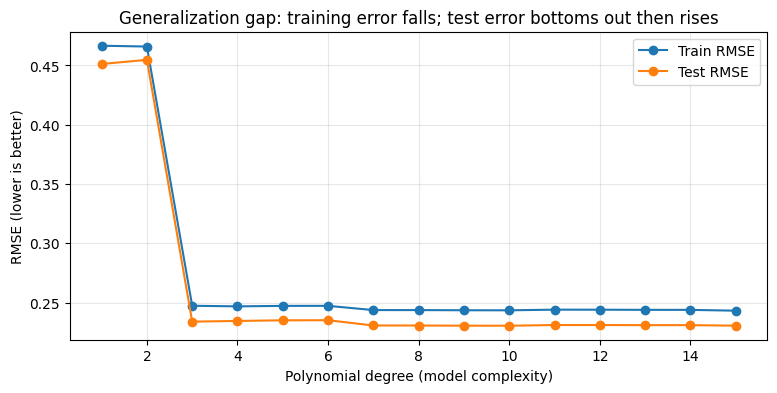

degree             10.000000
rmse_train          0.243504
rmse_test           0.230509
gap(test-train)    -0.012994
Name: 9, dtype: float64

In [4]:
plt.figure(figsize=(9, 4))
plt.plot(results_poly["degree"], results_poly["rmse_train"], marker="o", label="Train RMSE")
plt.plot(results_poly["degree"], results_poly["rmse_test"], marker="o", label="Test RMSE")
plt.xlabel("Polynomial degree (model complexity)")
plt.ylabel("RMSE (lower is better)")
plt.title("Generalization gap: training error falls; test error bottoms out then rises")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

best = results_poly.loc[results_poly["rmse_test"].idxmin()]
best

## 2. Evaluation protocols: how to estimate generalization honestly

### 2.1 Train / validation / test (and why it matters)

A standard, defensible protocol:

- **Train**: fit model parameters.
- **Validation**: tune hyperparameters; pick features; select model family.
- **Test**: estimate generalization once at the end.

If you repeatedly check test performance during tuning, you will implicitly overfit to the test set and report an optimistic score.

### 2.2 Cross-validation (CV)

$K$-fold CV partitions the data into $K$ folds and rotates the validation fold. Benefits:

- lower variance than a single split,
- uses data efficiently,
- supports uncertainty estimates (spread across folds).

But CV is not magic. It does **not** fix:

- **leakage**, if preprocessing is done outside a `Pipeline`,
- non-i.i.d. data (time series, groups, repeated entities),
- changing populations (drift).

### 2.3 Split strategy must match deployment reality

Choose the split based on how the model will be used:

- **Random split**: OK for i.i.d. settings.
- **Stratified split**: preserve class balance in classification.
- **Group split**: if multiple rows belong to a user/customer/device/patient.
- **Time-based split**: if you predict the future from the past (common in business).

A simple checklist:

- Are there duplicates or near-duplicates across splits?
- Are any features “post-outcome” (only known after the label occurs)?
- Does the target label itself leak into the features (directly or via proxies)?
- Is your split realistic (time or groups)?

### 2.4 Data leakage: the fastest path to fake “good performance”

**Leakage** is any information in training that would not be available at prediction time. Leakage can come from:

- “post-outcome” features (e.g., *payment status* when predicting default risk),
- data cleaning done using the full dataset (fit scalers/encoders on all rows),
- duplicates across splits (same customer appears in train and test),
- target leakage through engineered features (e.g., averaging future information),
- temporal leakage (random split when the model is used prospectively).

Leakage is dangerous because it produces **high metrics that collapse in production**.

A professional way to think about leakage:

- Leakage is not “a bug”; it is a **violation of the information set** available at prediction time.
- The fix is rarely “add regularization”. The fix is to **change the evaluation protocol and the feature pipeline**.

Below we build a tiny synthetic example that shows how one leaky feature can inflate accuracy. Then we remove it.

In [5]:
# Leakage demo: create a leaky feature that encodes the label (synthetic)

rng = np.random.default_rng(RANDOM_STATE)
n = 800

X_clean = rng.normal(size=(n, 5))
w = rng.normal(size=5)
logits = X_clean @ w
p = 1 / (1 + np.exp(-logits))
y = (rng.random(n) < p).astype(int)

# Leaky feature: y plus tiny noise (this is not available at prediction time in real life)
leaky = y + 0.01 * rng.normal(size=n)

X_leaky = np.column_stack([X_clean, leaky])

Xtr, Xte, ytr, yte = train_test_split(X_leaky, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y)

clf_leaky = LogisticRegression(max_iter=2000, random_state=RANDOM_STATE).fit(Xtr, ytr)
acc_leaky = accuracy_score(yte, clf_leaky.predict(Xte))

# Now remove the leaky column
Xtr2, Xte2, ytr2, yte2 = train_test_split(X_clean, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y)
clf_clean = LogisticRegression(max_iter=2000, random_state=RANDOM_STATE).fit(Xtr2, ytr2)
acc_clean = accuracy_score(yte2, clf_clean.predict(Xte2))

{"accuracy_with_leak": acc_leaky, "accuracy_without_leak": acc_clean}

{'accuracy_with_leak': 1.0, 'accuracy_without_leak': 0.7833333333333333}

In [6]:
# Example 2: Generalization estimate on a repo dataset (Iris)

df_iris = pd.read_csv(PATH_IRIS)
df_iris.head()

,sepal_length,sepal_width,petal_length,petal_width,classification
0,5.4,3.7,1.5,0.2,Iris-setosa
1,4.8,3.4,1.6,0.2,Iris-setosa
2,4.8,3.0,1.4,0.1,Iris-setosa
3,4.3,3.0,1.1,0.1,Iris-setosa
4,5.8,4.0,1.2,0.2,Iris-setosa


In [7]:
# Basic pipeline: scaling + multinomial logistic regression

X = df_iris.drop(columns=["classification"])
y = df_iris["classification"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=RANDOM_STATE,
    stratify=y
)

clf = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=2000, random_state=RANDOM_STATE))
])

clf.fit(X_train, y_train)

pred_train = clf.predict(X_train)
pred_test = clf.predict(X_test)

acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)

{"train_accuracy": acc_train, "test_accuracy": acc_test}

{'train_accuracy': 0.9523809523809523, 'test_accuracy': 0.9777777777777777}

In [8]:
print("Classification report (test):")
print(classification_report(y_test, pred_test))

labels = sorted(y.unique())
cm = confusion_matrix(y_test, pred_test, labels=labels)
pd.DataFrame(cm, index=labels, columns=labels)

Classification report (test):
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        15
Iris-versicolor       0.94      1.00      0.97        15
 Iris-virginica       1.00      0.93      0.97        15

       accuracy                           0.98        45
      macro avg       0.98      0.98      0.98        45
   weighted avg       0.98      0.98      0.98        45



,Iris-setosa,Iris-versicolor,Iris-virginica
Iris-setosa,15,0,0
Iris-versicolor,0,15,0
Iris-virginica,0,1,14


In [9]:
# Cross-validation estimate (accuracy)

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_scores = cross_val_score(clf, X, y, cv=cv, scoring="accuracy")

pd.Series(cv_scores).describe()

count    5.000000
mean     0.946667
std      0.064979
min      0.833333
25%      0.966667
50%      0.966667
75%      0.966667
max      1.000000
dtype: float64

## 3. Robustness: “How does it behave when reality is messy?”

Robustness is performance under **stress**. Real systems face:

- sensor noise,
- missing values,
- outliers and corrupted records,
- mild covariate shift (inputs drift),
- label noise and changing definitions.

A robust model is not one that never fails. It is one whose failures:

- are **understood**,
- are **bounded** (degradation is graceful),
- are **detectable** (monitoring signals exist),
- have a mitigation plan (fallback rules, retraining triggers, human review).

### 3.1 Stress testing is an engineering discipline

A robustness test plan should specify:

1. the stressor (what changes),
2. the mechanism (how it changes),
3. the metric (what you measure),
4. the expectation (how much degradation is acceptable),
5. the mitigation (what you do if it exceeds the bound).

Below we implement several stress tests using your repository datasets.

In [10]:
# Robustness test A: feature noise injection (Iris)

def add_feature_noise_df(X_df, sigma, seed=RANDOM_STATE):
    rng = np.random.default_rng(seed)
    noise = rng.normal(0, sigma, size=X_df.shape)
    Xn = X_df.to_numpy(dtype=float) + noise
    return pd.DataFrame(Xn, columns=X_df.columns, index=X_df.index)

sigmas = np.linspace(0.0, 0.8, 9)
accs = []

for s in sigmas:
    Xn = add_feature_noise_df(X_test, s)
    pred = clf.predict(Xn)
    accs.append(accuracy_score(y_test, pred))

noise_results = pd.DataFrame({"sigma": sigmas, "accuracy": accs})
noise_results


,sigma,accuracy
0,0.0,0.977778
1,0.1,0.933333
2,0.2,0.933333
3,0.3,0.911111
4,0.4,0.822222
5,0.5,0.822222
6,0.6,0.800000
7,0.7,0.733333
8,0.8,0.688889


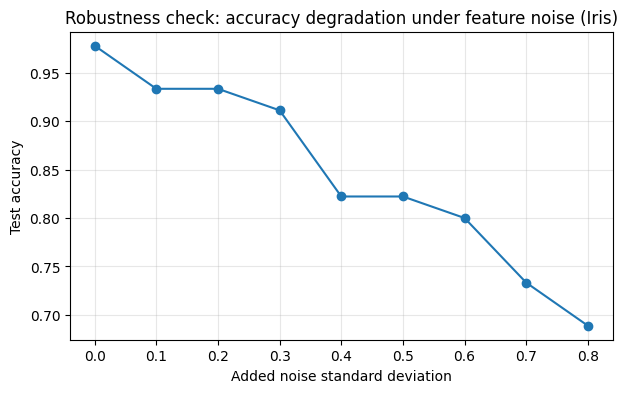

In [11]:
plt.figure(figsize=(7, 4))
plt.plot(noise_results["sigma"], noise_results["accuracy"], marker="o")
plt.xlabel("Added noise standard deviation")
plt.ylabel("Test accuracy")
plt.title("Robustness check: accuracy degradation under feature noise (Iris)")
plt.grid(True, alpha=0.3)
plt.show()

In [12]:
# Example 3: Diabetes dataset (binary classification) — load and inspect

df_diab = pd.read_csv(PATH_DIAB)
df_diab.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,classification
0,6,148,72,35,0,33.6,0.627,50,Diabetic
1,1,85,66,29,0,26.6,0.351,31,Non-Diabetic
2,8,183,64,0,0,23.3,0.672,32,Diabetic
3,1,89,66,23,94,28.1,0.167,21,Non-Diabetic
4,0,137,40,35,168,43.1,2.288,33,Diabetic


In [13]:
# Prepare diabetes features/labels.
# The CSV has label column "classification" with values like "Diabetic"/"Non-Diabetic".
# IMPORTANT: Do NOT encode by searching for substring "diab" because "Non-Diabetic" contains it too.

X_d = df_diab.drop(columns=["classification"]).copy()

labels = df_diab["classification"].astype(str).str.strip().str.lower()

# Robust mapping for common variants
map_dict = {
    "diabetic": 1,
    "non-diabetic": 0,
    "non diabetic": 0,
    "nondiabetic": 0,
    "non_diabetic": 0,
}
y_d = labels.map(map_dict)

# Fallback: if still missing, treat labels containing "non" as 0, otherwise 1
fallback = pd.Series(np.where(labels.str.contains("non", na=False), 0, 1), index=labels.index)
y_d = y_d.fillna(fallback).astype(int)

print("Class balance (0=Non-Diabetic, 1=Diabetic):")
display(y_d.value_counts())

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(
    X_d, y_d,
    test_size=0.30,
    random_state=RANDOM_STATE,
    stratify=y_d
)

# Pipeline: impute (median) + scale + logistic regression
pipe_lr = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=2000, random_state=RANDOM_STATE))
])

pipe_lr.fit(X_train_d, y_train_d)

proba = pipe_lr.predict_proba(X_test_d)[:, 1]
pred = (proba >= 0.5).astype(int)

{
    "test_accuracy@0.5": accuracy_score(y_test_d, pred),
    "test_precision@0.5": precision_score(y_test_d, pred, zero_division=0),
    "test_recall@0.5": recall_score(y_test_d, pred, zero_division=0),
    "test_f1@0.5": f1_score(y_test_d, pred, zero_division=0),
    "brier_score": brier_score_loss(y_test_d, proba),
    "log_loss": log_loss(y_test_d, np.column_stack([1-proba, proba])),
}


Class balance (0=Non-Diabetic, 1=Diabetic):


classification
0    500
1    268
Name: count, dtype: int64

{'test_accuracy@0.5': 0.7705627705627706,
 'test_precision@0.5': np.float64(0.7333333333333333),
 'test_recall@0.5': np.float64(0.5432098765432098),
 'test_f1@0.5': np.float64(0.624113475177305),
 'brier_score': np.float64(0.1618530425870285),
 'log_loss': 0.483718027985991}

### 3.2 Missingness stress test: performance as data goes missing

Missing values are common: broken sensors, incomplete forms, delayed pipelines.

A robust evaluation asks:

- which features are likely to become missing,
- whether missingness is random or systematic (conceptually MCAR/MAR/MNAR),
- how performance degrades as missingness increases,
- how much *coverage* you lose if you drop missing rows.

We stress-test missingness by injecting NaNs at increasing rates and comparing strategies.

In [14]:
# Robustness test B: missingness injection (diabetes)

def inject_missing_values_df(X_df, missing_rate, seed=RANDOM_STATE):
    rng = np.random.default_rng(seed)
    X_arr = X_df.to_numpy(dtype=float, copy=True)
    mask = rng.random(X_arr.shape) < missing_rate
    X_arr[mask] = np.nan
    return pd.DataFrame(X_arr, columns=X_df.columns, index=X_df.index)

rates = [0.0, 0.05, 0.10, 0.20, 0.30, 0.40]
rows = []

for r in rates:
    X_m = inject_missing_values_df(X_test_d, r, seed=RANDOM_STATE)

    # Strategy 1: pipeline with imputation (keeps all rows)
    proba_r = pipe_lr.predict_proba(X_m)[:, 1]
    pred_r = (proba_r >= 0.5).astype(int)
    rows.append(("impute+LR", r, len(y_test_d), accuracy_score(y_test_d, pred_r), brier_score_loss(y_test_d, proba_r)))

    # Strategy 2: drop any row with missing values (coverage loss)
    keep = ~X_m.isna().any(axis=1)
    if int(keep.sum()) > 0:
        proba_drop = pipe_lr.predict_proba(X_m.loc[keep])[:, 1]
        pred_drop = (proba_drop >= 0.5).astype(int)
        rows.append(("drop-missing", r, int(keep.sum()),
                    accuracy_score(y_test_d.loc[keep], pred_drop),
                    brier_score_loss(y_test_d.loc[keep], proba_drop)))
    else:
        rows.append(("drop-missing", r, 0, np.nan, np.nan))

miss_df = pd.DataFrame(rows, columns=["strategy", "missing_rate", "n_evaluated", "accuracy", "brier"])
miss_df


,strategy,missing_rate,n_evaluated,accuracy,brier
0,impute+LR,0.00,231,0.770563,0.161853
1,drop-missing,0.00,231,0.770563,0.161853
2,impute+LR,0.05,231,0.774892,0.161464
3,drop-missing,0.05,157,0.757962,0.173835
4,impute+LR,0.10,231,0.766234,0.167236
5,drop-missing,0.10,97,0.804124,0.140278
6,impute+LR,0.20,231,0.744589,0.174757
7,drop-missing,0.20,38,0.763158,0.142444
8,impute+LR,0.30,231,0.735931,0.188950
9,drop-missing,0.30,12,0.916667,0.086343


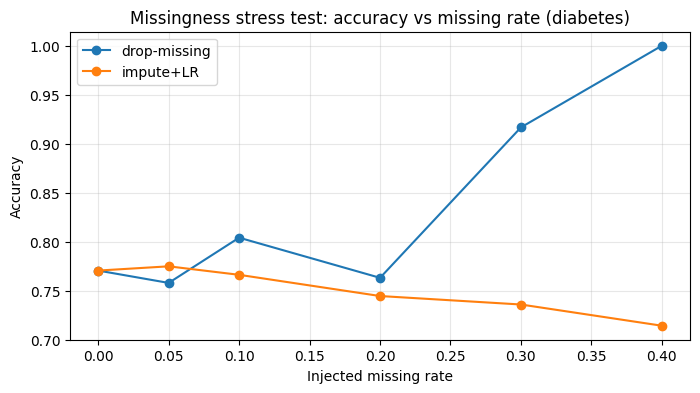

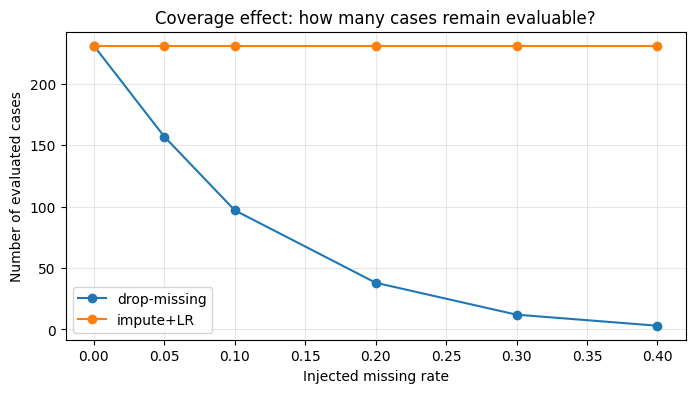

In [15]:
plt.figure(figsize=(8, 4))
for strategy, grp in miss_df.groupby("strategy"):
    plt.plot(grp["missing_rate"], grp["accuracy"], marker="o", label=strategy)
plt.xlabel("Injected missing rate")
plt.ylabel("Accuracy")
plt.title("Missingness stress test: accuracy vs missing rate (diabetes)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(8, 4))
for strategy, grp in miss_df.groupby("strategy"):
    plt.plot(grp["missing_rate"], grp["n_evaluated"], marker="o", label=strategy)
plt.xlabel("Injected missing rate")
plt.ylabel("Number of evaluated cases")
plt.title("Coverage effect: how many cases remain evaluable?")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 3.3 Outliers stress test: regression sensitivity

Outliers are common in numeric regressions (data entry errors, rare events, upstream bugs).

Least-squares regression is known to be sensitive because squaring emphasizes large deviations.
Robust regression (e.g., Huber) usually degrades more gracefully.

We use the `house-prices.csv` schema from your repository and compare Linear Regression and Huber regression.

In [16]:
df_house = pd.read_csv(PATH_HOUSE)
df_house.head()

,Home,Price,SqFt,Bedrooms,Bathrooms,Offers,Brick,Neighborhood
0,1,114300,1790,2,2,2,No,East
1,2,114200,2030,4,2,3,No,East
2,3,114800,1740,3,2,1,No,East
3,4,94700,1980,3,2,3,No,East
4,5,119800,2130,3,3,3,No,East


In [17]:
# Prepare regression problem: predict Price from features

X_h = df_house.drop(columns=["Price"])
y_h = df_house["Price"]

num_cols = ["SqFt", "Bedrooms", "Bathrooms", "Offers"]
cat_cols = ["Brick", "Neighborhood"]

pre = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imp", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]), num_cols),
        ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")), ("ohe", OneHotEncoder(handle_unknown="ignore"))]), cat_cols),
    ]
)

lin_reg = Pipeline([("pre", pre), ("model", LinearRegression())])
huber_reg = Pipeline([("pre", pre), ("model", HuberRegressor())])

X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(
    X_h, y_h, test_size=0.30, random_state=RANDOM_STATE
)

lin_reg.fit(X_train_h, y_train_h)
huber_reg.fit(X_train_h, y_train_h)

pred_lin = lin_reg.predict(X_test_h)
pred_hub = huber_reg.predict(X_test_h)

rmse_lin = math.sqrt(mean_squared_error(y_test_h, pred_lin))
rmse_hub = math.sqrt(mean_squared_error(y_test_h, pred_hub))
mae_lin = mean_absolute_error(y_test_h, pred_lin)
mae_hub = mean_absolute_error(y_test_h, pred_hub)

pd.DataFrame({
    "model": ["LinearRegression", "HuberRegressor"],
    "RMSE": [rmse_lin, rmse_hub],
    "MAE": [mae_lin, mae_hub]
})

,model,RMSE,MAE
0,LinearRegression,9389.447163,7353.620381
1,HuberRegressor,9779.813053,7749.288434


In [18]:
# Inject outliers into the TEST set and compare degradation

X_test_out = X_test_h.copy()
y_test_out = y_test_h.copy()

rng = np.random.default_rng(RANDOM_STATE)
out_idx = rng.choice(X_test_out.index, size=max(1, int(0.10 * len(X_test_out))), replace=False)

# Inflate SqFt dramatically and scale up price to simulate extreme cases / corrupted records
X_test_out.loc[out_idx, "SqFt"] = X_test_out.loc[out_idx, "SqFt"] * 3
y_test_out.loc[out_idx] = y_test_out.loc[out_idx] * 2

pred_lin_out = lin_reg.predict(X_test_out)
pred_hub_out = huber_reg.predict(X_test_out)

rmse_lin_out = math.sqrt(mean_squared_error(y_test_out, pred_lin_out))
rmse_hub_out = math.sqrt(mean_squared_error(y_test_out, pred_hub_out))
mae_lin_out = mean_absolute_error(y_test_out, pred_lin_out)
mae_hub_out = mean_absolute_error(y_test_out, pred_hub_out)

pd.DataFrame({
    "scenario": ["clean test", "with outliers (10%)"],
    "RMSE LinearRegression": [rmse_lin, rmse_lin_out],
    "RMSE HuberRegressor": [rmse_hub, rmse_hub_out],
    "MAE LinearRegression": [mae_lin, mae_lin_out],
    "MAE HuberRegressor": [mae_hub, mae_hub_out],
})

,scenario,RMSE LinearRegression,RMSE HuberRegressor,MAE LinearRegression,MAE HuberRegressor
0,clean test,9389.447163,9779.813053,7353.620381,7749.288434
1,with outliers (10%),23559.911411,23027.137694,12309.994639,12318.464507


### 3.4 Label noise and class imbalance: robustness beyond “clean labels”

Real-world labels are often imperfect:

- ambiguous definitions (what counts as “fraud”?),
- inconsistent annotators,
- delayed ground truth updates,
- proxies used as labels (clicks, refunds, churn risk).

Label noise interacts with class imbalance:

- In rare-event problems, a small number of mislabeled positives/negatives can dominate evaluation.
- Accuracy becomes misleading; precision–recall and calibration matter more.

A practical robustness step is to:

1. measure class balance,
2. use metrics suited to the imbalance (precision/recall/F1, PR curves),
3. compare models with and without class weights,
4. test sensitivity by flipping a fraction of labels (synthetic stress).

We demonstrate this using the Wine Quality dataset by binarizing the target into “high quality” vs “not high quality”.

In [19]:
# Wine Quality: load and build a binary classification problem

df_wine = pd.read_csv(PATH_WINE)
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [20]:
# Binarize: "high quality" = quality >= 7 (you can adjust based on course preference)

X_w = df_wine.drop(columns=["quality"])
y_w = (df_wine["quality"] >= 7).astype(int)

y_w.value_counts(normalize=True)

quality
0    0.783585
1    0.216415
Name: proportion, dtype: float64

In [21]:
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(
    X_w, y_w, test_size=0.30, random_state=RANDOM_STATE, stratify=y_w
)

pipe_w = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=3000, random_state=RANDOM_STATE))
])

pipe_w.fit(X_train_w, y_train_w)
proba_w = pipe_w.predict_proba(X_test_w)[:, 1]
pred_w = (proba_w >= 0.5).astype(int)

{
    "accuracy": accuracy_score(y_test_w, pred_w),
    "precision": precision_score(y_test_w, pred_w, zero_division=0),
    "recall": recall_score(y_test_w, pred_w, zero_division=0),
    "f1": f1_score(y_test_w, pred_w, zero_division=0),
    "brier": brier_score_loss(y_test_w, proba_w),
}

{'accuracy': 0.8034013605442177,
 'precision': np.float64(0.6074074074074074),
 'recall': np.float64(0.2578616352201258),
 'f1': np.float64(0.3620309050772627),
 'brier': np.float64(0.13446213478413008)}

In [22]:
# Compare with class_weight="balanced"

pipe_w_bal = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=3000, random_state=RANDOM_STATE, class_weight="balanced"))
])

pipe_w_bal.fit(X_train_w, y_train_w)
proba_wb = pipe_w_bal.predict_proba(X_test_w)[:, 1]
pred_wb = (proba_wb >= 0.5).astype(int)

pd.DataFrame([
    ("baseline", accuracy_score(y_test_w, pred_w), precision_score(y_test_w, pred_w, zero_division=0), recall_score(y_test_w, pred_w, zero_division=0), f1_score(y_test_w, pred_w, zero_division=0)),
    ("class_weight=balanced", accuracy_score(y_test_w, pred_wb), precision_score(y_test_w, pred_wb, zero_division=0), recall_score(y_test_w, pred_wb, zero_division=0), f1_score(y_test_w, pred_wb, zero_division=0)),
], columns=["setting", "accuracy", "precision", "recall", "f1"])

,setting,accuracy,precision,recall,f1
0,baseline,0.803401,0.607407,0.257862,0.362031
1,class_weight=balanced,0.709524,0.405872,0.738994,0.523969


In [23]:
# Label noise stress: flip a fraction of TRAIN labels and re-evaluate

def flip_labels(y_array, flip_rate, seed=RANDOM_STATE):
    rng = np.random.default_rng(seed)
    y = y_array.copy()
    idx = rng.choice(len(y), size=int(flip_rate * len(y)), replace=False)
    y[idx] = 1 - y[idx]
    return y

flip_rates = [0.0, 0.05, 0.10, 0.20]
rows = []

for fr in flip_rates:
    y_train_noisy = flip_labels(y_train_w.to_numpy(), fr, seed=RANDOM_STATE)
    pipe_tmp = Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("lr", LogisticRegression(max_iter=3000, random_state=RANDOM_STATE, class_weight="balanced"))
    ])
    pipe_tmp.fit(X_train_w, y_train_noisy)

    proba_tmp = pipe_tmp.predict_proba(X_test_w)[:, 1]
    pred_tmp = (proba_tmp >= 0.5).astype(int)

    rows.append((
        fr,
        accuracy_score(y_test_w, pred_tmp),
        precision_score(y_test_w, pred_tmp, zero_division=0),
        recall_score(y_test_w, pred_tmp, zero_division=0),
        f1_score(y_test_w, pred_tmp, zero_division=0),
        brier_score_loss(y_test_w, proba_tmp)
    ))

pd.DataFrame(rows, columns=["flip_rate", "accuracy", "precision", "recall", "f1", "brier"])

,flip_rate,accuracy,precision,recall,f1,brier
0,0.00,0.709524,0.405872,0.738994,0.523969,0.186235
1,0.05,0.694558,0.395200,0.776730,0.523860,0.195422
2,0.10,0.688435,0.390282,0.783019,0.520921,0.205140
3,0.20,0.682993,0.386154,0.789308,0.518595,0.219284


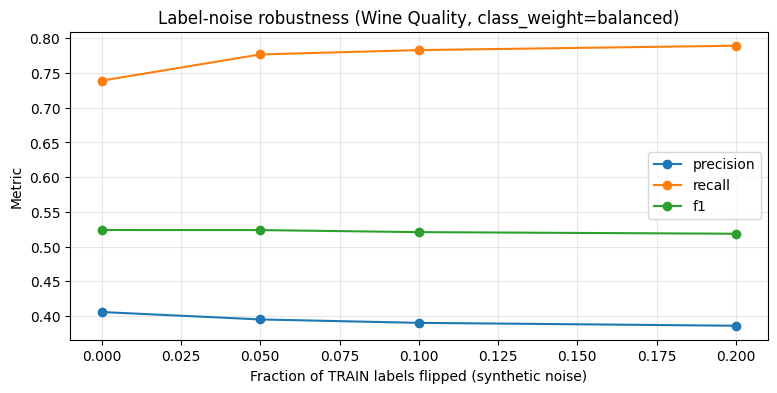

In [24]:
# Visualize degradation of recall / precision with label noise

df_flip = pd.DataFrame(rows, columns=["flip_rate", "accuracy", "precision", "recall", "f1", "brier"])

plt.figure(figsize=(9, 4))
plt.plot(df_flip["flip_rate"], df_flip["precision"], marker="o", label="precision")
plt.plot(df_flip["flip_rate"], df_flip["recall"], marker="o", label="recall")
plt.plot(df_flip["flip_rate"], df_flip["f1"], marker="o", label="f1")
plt.xlabel("Fraction of TRAIN labels flipped (synthetic noise)")
plt.ylabel("Metric")
plt.title("Label-noise robustness (Wine Quality, class_weight=balanced)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 4. Reliability: calibration, thresholds, uncertainty, stability

Reliability means you can **trust**:

- the probabilities (if you output probabilities),
- the decision thresholds (if you trigger actions),
- the reported metrics (with uncertainty, not just point estimates),
- the stability across reruns and splits.

### 4.1 Probability calibration (classification)

If a model predicts $p=0.8$, then among cases with predicted probability near 0.8, the empirical positive rate should be close to 0.8.

Two common tools:

- **Brier score**: mean squared error of probabilities; lower is better.
- **Reliability diagram**: compares predicted probabilities to observed frequencies.

Below we compare Logistic Regression and Random Forest on the diabetes dataset.

In [25]:
# Reliability test A: calibration comparison (diabetes)

rf = RandomForestClassifier(
    n_estimators=400,
    random_state=RANDOM_STATE,
    min_samples_leaf=3
)

# RandomForest cannot handle NaNs, so we use the imputed data explicitly
X_train_d_imp = SimpleImputer(strategy="median").fit_transform(X_train_d)
X_test_d_imp = SimpleImputer(strategy="median").fit(X_train_d).transform(X_test_d)

rf.fit(X_train_d_imp, y_train_d)

proba_lr = pipe_lr.predict_proba(X_test_d)[:, 1]
proba_rf = rf.predict_proba(X_test_d_imp)[:, 1]

brier_lr = brier_score_loss(y_test_d, proba_lr)
brier_rf = brier_score_loss(y_test_d, proba_rf)

pd.DataFrame({
    "model": ["LogisticRegression (pipeline)", "RandomForest (imputed)"],
    "brier_score": [brier_lr, brier_rf],
    "accuracy@0.5": [
        accuracy_score(y_test_d, (proba_lr >= 0.5).astype(int)),
        accuracy_score(y_test_d, (proba_rf >= 0.5).astype(int))
    ]
})

,model,brier_score,accuracy@0.5
0,LogisticRegression (pipeline),0.161853,0.770563
1,RandomForest (imputed),0.161402,0.757576


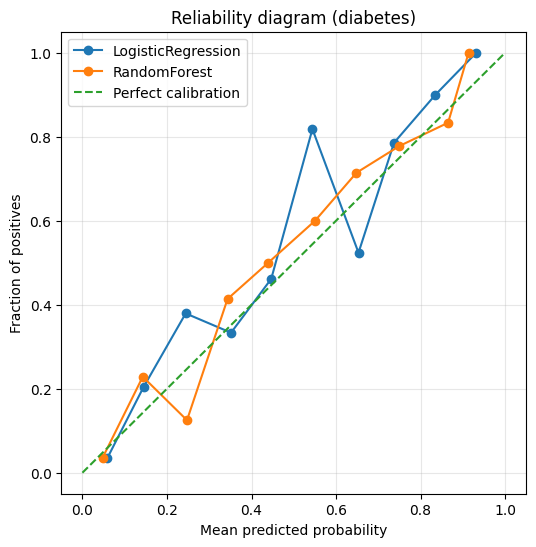

In [26]:
frac_pos_lr, mean_pred_lr = calibration_curve(y_test_d, proba_lr, n_bins=10, strategy="uniform")
frac_pos_rf, mean_pred_rf = calibration_curve(y_test_d, proba_rf, n_bins=10, strategy="uniform")

plt.figure(figsize=(6, 6))
plt.plot(mean_pred_lr, frac_pos_lr, marker="o", label="LogisticRegression")
plt.plot(mean_pred_rf, frac_pos_rf, marker="o", label="RandomForest")
plt.plot([0, 1], [0, 1], linestyle="--", label="Perfect calibration")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Reliability diagram (diabetes)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 4.2 Decision thresholds are part of the model

If you convert probabilities to decisions, you must choose a threshold $t$.

- $t=0.5$ is rarely optimal.
- In imbalanced or high-cost settings, you may prefer higher recall (lower threshold) or higher precision (higher threshold).

You should select thresholds based on:

- business/safety costs (false negative vs false positive),
- capacity constraints (how many alerts can be handled),
- fairness constraints (avoid systematically worse outcomes for groups).

We compute metrics across thresholds to visualize tradeoffs.

In [27]:
# Threshold sweep (diabetes Logistic Regression)

thresholds = np.linspace(0.05, 0.95, 19)
rows = []

for t in thresholds:
    pred_t = (proba_lr >= t).astype(int)
    rows.append((
        t,
        precision_score(y_test_d, pred_t, zero_division=0),
        recall_score(y_test_d, pred_t, zero_division=0),
        f1_score(y_test_d, pred_t, zero_division=0),
        accuracy_score(y_test_d, pred_t),
    ))

th_df = pd.DataFrame(rows, columns=["threshold", "precision", "recall", "f1", "accuracy"])
th_df.head()

,threshold,precision,recall,f1,accuracy
0,0.05,0.393204,1.000000,0.564460,0.458874
1,0.10,0.456647,0.975309,0.622047,0.584416
2,0.15,0.517007,0.938272,0.666667,0.670996
3,0.20,0.542636,0.864198,0.666667,0.696970
4,0.25,0.562500,0.777778,0.652850,0.709957


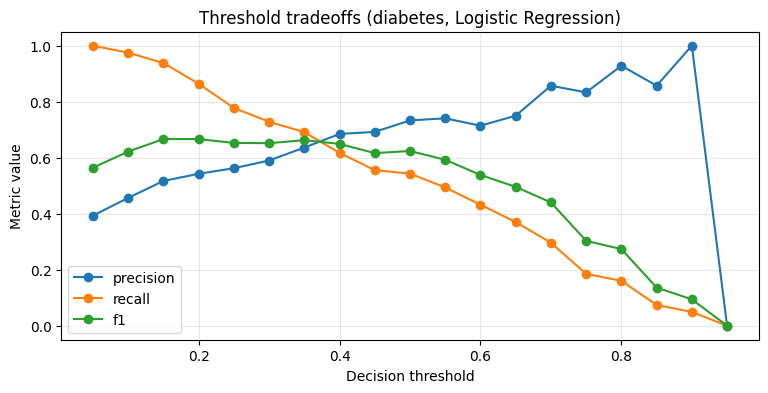

threshold    0.150000
precision    0.517007
recall       0.938272
f1           0.666667
accuracy     0.670996
Name: 2, dtype: float64

In [28]:
plt.figure(figsize=(9, 4))
plt.plot(th_df["threshold"], th_df["precision"], marker="o", label="precision")
plt.plot(th_df["threshold"], th_df["recall"], marker="o", label="recall")
plt.plot(th_df["threshold"], th_df["f1"], marker="o", label="f1")
plt.xlabel("Decision threshold")
plt.ylabel("Metric value")
plt.title("Threshold tradeoffs (diabetes, Logistic Regression)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

th_df.loc[th_df["f1"].idxmax()]

### 4.3 Cohort reliability: average metrics can hide concentrated failures

It is common to see “overall accuracy = 90%” while a specific cohort fails badly.

A basic pattern:

1. define meaningful cohorts (age bands, geography, device type, acquisition channel),
2. compute metrics per cohort,
3. investigate gaps, and decide whether to mitigate or restrict use.

Below we create age bands for diabetes and compute accuracy and Brier score per band.

In [29]:
df_eval = X_test_d.copy()
df_eval["y_true"] = y_test_d.to_numpy()
df_eval["p_hat"] = proba_lr
df_eval["pred_0_5"] = (df_eval["p_hat"] >= 0.5).astype(int)

df_eval["age_band"] = pd.cut(df_eval["Age"], bins=[0, 30, 45, 60, 120], right=True)

rows = []
for band, grp in df_eval.groupby("age_band"):
    rows.append((
        str(band),
        len(grp),
        accuracy_score(grp["y_true"], grp["pred_0_5"]),
        brier_score_loss(grp["y_true"], grp["p_hat"])
    ))

pd.DataFrame(rows, columns=["age_band", "n", "accuracy@0.5", "brier"]).sort_values("age_band")

C:\Users\LENOVO.PIESC\AppData\Local\Temp\ipykernel_20484\608785846.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for band, grp in df_eval.groupby("age_band"):


,age_band,n,accuracy@0.5,brier
0,"(0, 30]",129,0.868217,0.106203
1,"(30, 45]",62,0.661290,0.219123
2,"(45, 60]",31,0.612903,0.263877
3,"(60, 120]",9,0.666667,0.213564


### 4.4 Reliability in regression: prediction intervals (quantile regression)

For regression, “reliability” often means your predicted *ranges* are honest.

One practical approach is to estimate conditional quantiles:

- lower quantile (e.g., 10th percentile),
- median (50th percentile),
- upper quantile (90th percentile).

If your 10–90% interval is calibrated, then about **80%** of true targets should fall within the interval.

We fit quantile gradient boosting regressors on house prices and check coverage.

In [30]:
from sklearn.metrics import mean_pinball_loss

def quantile_model(alpha):
    return Pipeline([
        ("pre", pre),
        ("gbr", GradientBoostingRegressor(loss="quantile", alpha=alpha, random_state=RANDOM_STATE))
    ])

q10 = quantile_model(0.10).fit(X_train_h, y_train_h)
q50 = quantile_model(0.50).fit(X_train_h, y_train_h)
q90 = quantile_model(0.90).fit(X_train_h, y_train_h)

pred_10 = q10.predict(X_test_h)
pred_50 = q50.predict(X_test_h)
pred_90 = q90.predict(X_test_h)

coverage = np.mean((y_test_h.to_numpy() >= pred_10) & (y_test_h.to_numpy() <= pred_90))
pinball_10 = mean_pinball_loss(y_test_h, pred_10, alpha=0.10)
pinball_90 = mean_pinball_loss(y_test_h, pred_90, alpha=0.90)

pd.DataFrame({
    "metric": ["interval_coverage_10_90", "pinball_loss_q10", "pinball_loss_q90"],
    "value": [coverage, pinball_10, pinball_90]
})

,metric,value
0,interval_coverage_10_90,0.512821
1,pinball_loss_q10,3394.032223
2,pinball_loss_q90,2525.307854


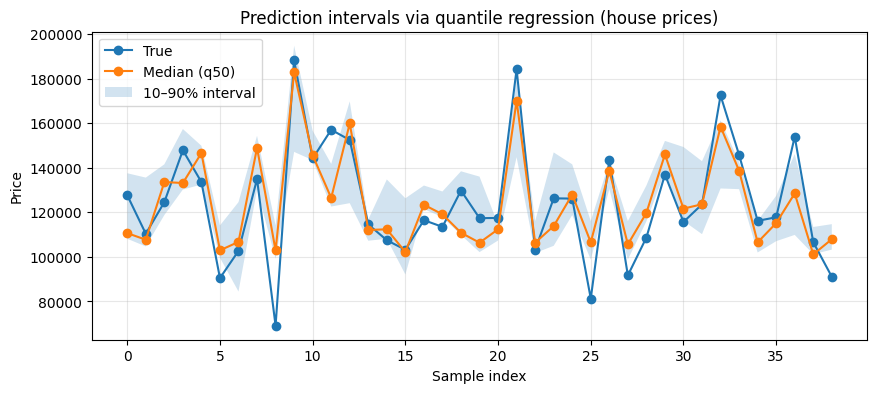

In [31]:
# Visualize intervals for a subset

sample = pd.DataFrame({
    "y_true": y_test_h.to_numpy(),
    "q10": pred_10,
    "q50": pred_50,
    "q90": pred_90
}).head(40)

x = np.arange(len(sample))

plt.figure(figsize=(10, 4))
plt.plot(x, sample["y_true"].to_numpy(dtype=float), marker="o", label="True")
plt.plot(x, sample["q50"].to_numpy(dtype=float), marker="o", label="Median (q50)")
plt.fill_between(x, sample["q10"].to_numpy(dtype=float), sample["q90"].to_numpy(dtype=float), alpha=0.2, label="10–90% interval")
plt.xlabel("Sample index")
plt.ylabel("Price")
plt.title("Prediction intervals via quantile regression (house prices)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 4.5 Reliability is not only calibration: “can I trust the experiment?”

In a mature ML workflow, reliability also includes the **reliability of the evaluation itself**:

- **Reproducibility**: if you rerun the same notebook, do you get the same results (within small numerical differences)?
- **Traceability**: can you explain which data, code, and parameters produced the reported number?
- **Auditability**: can an independent reviewer verify the evaluation without guesswork?

Practical habits that increase evaluation reliability:

- Set random seeds (and record them).
- Use `Pipeline` so preprocessing is fitted only on training folds.
- Record versions: Python, library versions, dataset hashes, feature lists.
- Separate model selection (validation) from final reporting (test).
- Report uncertainty: fold spread, bootstrap intervals, or repeated split variability.

A high metric without these habits is not a reliable claim; it is a fragile anecdote.

## 5. Stability: reproducibility across seeds and splits

A single split can be lucky. “Good” performance should be **stable**.

Two practical checks:

1. repeated train/test splits with different random seeds,
2. cross-validation spread (variance across folds).

Below we repeat the Iris experiment for many seeds and summarize variability.

In [32]:
seeds = list(range(1, 101))
accs = []

for s in seeds:
    X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
        X, y, test_size=0.30, random_state=s, stratify=y
    )
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LogisticRegression(max_iter=2000, random_state=s))
    ])
    model.fit(X_train_s, y_train_s)
    accs.append(accuracy_score(y_test_s, model.predict(X_test_s)))

pd.Series(accs).describe()

count    100.000000
mean       0.955111
std        0.026797
min        0.888889
25%        0.933333
50%        0.955556
75%        0.977778
max        1.000000
dtype: float64

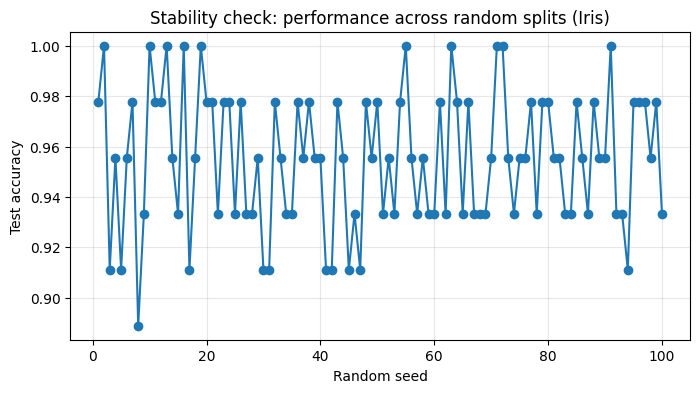

In [33]:
plt.figure(figsize=(8, 4))
plt.plot(seeds, accs, marker="o")
plt.xlabel("Random seed")
plt.ylabel("Test accuracy")
plt.title("Stability check: performance across random splits (Iris)")
plt.grid(True, alpha=0.3)
plt.show()

## 6. Distribution shift: a minimal, practical simulation

Many production failures occur because the deployment inputs differ from training inputs.

Even if you do not have labels for the shifted data, you can still monitor drift by tracking:

- feature means/quantiles and missing rates,
- distance-based summaries (e.g., embedding distances),
- divergence measures (e.g., PSI),
- drift tests (e.g., KS test) on key continuous variables.

We use the `airports.csv` schema and simulate a shift in latitude/longitude to show how structure can move.

In [34]:
df_air = pd.read_csv(PATH_AIRPORTS)

# Keep only rows with valid geo coordinates (many datasets contain missing entries)
df_air_geo = df_air[["latitude_deg", "longitude_deg"]].dropna().copy()
df_air_geo.head()


,latitude_deg,longitude_deg
0,40.070985,-74.933689
1,38.704022,-101.473911
2,59.947733,-151.692524
3,34.864799,-86.770302
4,59.093287,-156.456699


In [35]:
from sklearn.cluster import KMeans

X_air = df_air_geo[["latitude_deg", "longitude_deg"]].to_numpy(dtype=float)

kmeans = KMeans(n_clusters=2, random_state=RANDOM_STATE, n_init=10).fit(X_air)
labels_base = kmeans.labels_

# Simulate a shift (toy): systematic offset
X_shift = X_air.copy()
X_shift[:, 0] += 3.0
X_shift[:, 1] += -5.0

labels_shift = kmeans.predict(X_shift)

pd.DataFrame({
    "base_cluster": labels_base,
    "shifted_cluster": labels_shift,
    "lat": X_air[:, 0],
    "lon": X_air[:, 1],
}).head(10)


,base_cluster,shifted_cluster,lat,lon
0,0,0,40.070985,-74.933689
1,0,0,38.704022,-101.473911
2,0,0,59.947733,-151.692524
3,0,0,34.864799,-86.770302
4,0,0,59.093287,-156.456699
5,0,0,34.942803,-97.818019
6,0,0,34.305599,-112.165001
7,0,0,35.354740,-116.885329
8,0,0,39.427188,-121.763427
9,0,0,32.727374,-116.459742


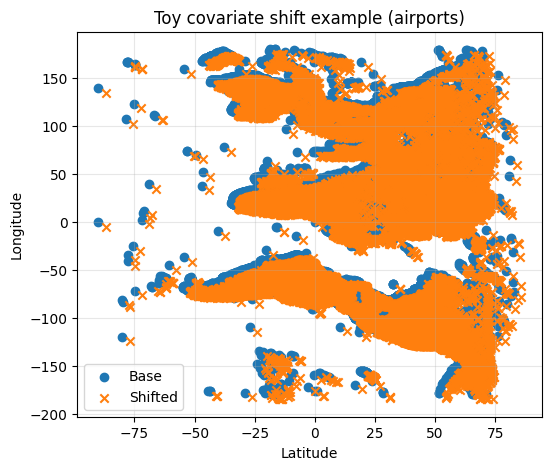

In [36]:
plt.figure(figsize=(6, 5))
plt.scatter(X_air[:, 0], X_air[:, 1], marker="o", label="Base")
plt.scatter(X_shift[:, 0], X_shift[:, 1], marker="x", label="Shifted")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Toy covariate shift example (airports)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 6.1 Practical drift monitoring metric: Population Stability Index (PSI)

PSI is a simple, widely used operational metric to compare a feature distribution between two samples
(e.g., training vs recent production). It is not perfect, but it is easy to compute and explain.

Procedure:

1. Bin a feature using training quantiles (fixed bins).
2. Compute bin proportions in baseline vs new sample.
3. Sum:
   $$\text{PSI} = \sum_i (p_i - q_i)\ln\left(\frac{p_i}{q_i}\right)$$

Rules of thumb (context-dependent):

- PSI < 0.1: small drift
- 0.1–0.25: moderate drift
- > 0.25: large drift (investigate)

Below we compute PSI on diabetes features by simulating a shifted “production” sample.

In [37]:
def psi(base, new, bins=10, eps=1e-6):
    # base/new are 1D numpy arrays
    base = np.asarray(base, dtype=float)
    new = np.asarray(new, dtype=float)

    # Bin edges from base quantiles
    quantiles = np.linspace(0, 1, bins + 1)
    edges = np.quantile(base[~np.isnan(base)], quantiles)

    # Avoid identical edges
    edges[0] = -np.inf
    edges[-1] = np.inf

    base_counts, _ = np.histogram(base, bins=edges)
    new_counts, _ = np.histogram(new, bins=edges)

    p = base_counts / max(1, base_counts.sum())
    q = new_counts / max(1, new_counts.sum())

    p = np.clip(p, eps, 1.0)
    q = np.clip(q, eps, 1.0)

    return float(np.sum((p - q) * np.log(p / q)))

# Simulate a "production" shift on diabetes features: increase Glucose and BMI slightly
X_base = X_train_d.copy()
X_prod = X_train_d.copy()

X_prod = X_prod.copy()
X_prod["Glucose"] = X_prod["Glucose"] * 1.08
X_prod["BMI"] = X_prod["BMI"] * 1.05

psi_rows = []
for col in X_base.columns:
    psi_rows.append((col, psi(X_base[col].to_numpy(), X_prod[col].to_numpy(), bins=10)))

psi_df = pd.DataFrame(psi_rows, columns=["feature", "PSI"]).sort_values("PSI", ascending=False)
psi_df.head(10)

,feature,PSI
1,Glucose,0.094033
5,BMI,0.052478
2,BloodPressure,0.000000
0,Pregnancies,0.000000
3,SkinThickness,0.000000
4,Insulin,0.000000
6,DiabetesPedigreeFunction,0.000000
7,Age,0.000000


## 7. Metric uncertainty: bootstrap confidence intervals

A single metric is incomplete without uncertainty.

A practical method is the **bootstrap**:

1. sample test cases with replacement,
2. compute the metric on each resample,
3. take quantiles as confidence intervals.

This estimates the variability due to finite test samples.

We compute a 95% bootstrap interval for accuracy on diabetes (Logistic Regression, threshold 0.5).

In [38]:
rng = np.random.default_rng(RANDOM_STATE)

pred_05 = (proba_lr >= 0.5).astype(int)
y_true = y_test_d.to_numpy()

n = len(y_true)
B = 1000

acc_boot = np.empty(B)
for b in range(B):
    idx = rng.integers(0, n, size=n)
    acc_boot[b] = accuracy_score(y_true[idx], pred_05[idx])

ci_low, ci_high = np.quantile(acc_boot, [0.025, 0.975])
acc_point = accuracy_score(y_true, pred_05)

{"point_accuracy": acc_point, "ci_95%": (ci_low, ci_high), "bootstrap_std": acc_boot.std()}

{'point_accuracy': 0.7705627705627706,
 'ci_95%': (np.float64(0.7142857142857143), np.float64(0.8225108225108225)),
 'bootstrap_std': np.float64(0.027642764179781936)}

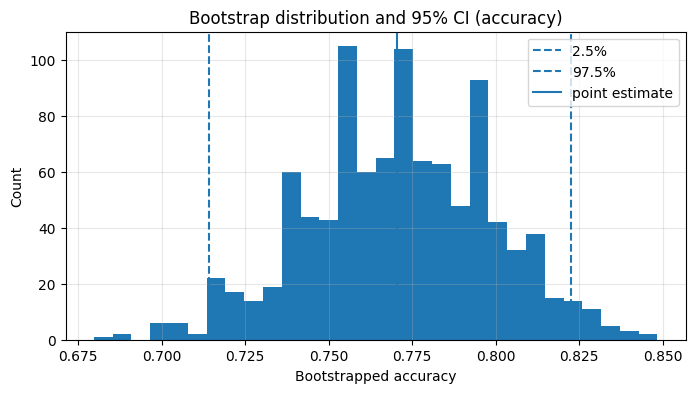

In [39]:
plt.figure(figsize=(8, 4))
plt.hist(acc_boot, bins=30)
plt.axvline(ci_low, linestyle="--", label="2.5%")
plt.axvline(ci_high, linestyle="--", label="97.5%")
plt.axvline(acc_point, linestyle="-", label="point estimate")
plt.xlabel("Bootstrapped accuracy")
plt.ylabel("Count")
plt.title("Bootstrap distribution and 95% CI (accuracy)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 8. Deliverable: a one-page evaluation memo (template)

In professional ML, you do not “ship a metric”. You ship a decision supported by an evaluation record.

Use the template below to communicate clearly and defensibly.

### Evaluation memo template

**Problem**  
- Task: classification/regression; unit of prediction; label definition; who/what acts on the output.

**Data**  
- Source(s), time window, sampling/filtering, known quality issues.  
- Split strategy and justification (random/stratified/group/time).  
- Leakage checks performed (preprocessing in pipelines, post-outcome features removed, duplicates handled).

**Models compared**  
- Baselines (rules, linear) and candidate models (trees/ensembles).

**Metrics**  
- Primary metric(s) and why (cost alignment).  
- Secondary metrics (calibration, latency, interpretability).  
- Threshold selection policy (if applicable).

**Results (with uncertainty)**  
- Final test estimate + CV spread or bootstrap CI.  
- Cohort breakdown (identify worst slices).

**Robustness tests**  
- Noise / missingness / outliers / shift scenarios.  
- Degradation bounds and mitigations.

**Reliability**  
- Calibration evidence (Brier + reliability diagram).  
- Regression interval coverage (if regression).  
- Stability across reruns / seeds.

**Decision**  
- Ship / do not ship / ship behind a feature flag.  
- Monitoring signals and rollback plan.

This memo turns “model performance” into an accountable engineering decision.

## 9. Summary: what “good performance” really means

A model is “good” when it is:

1. **Generalizing**: strong out-of-sample performance under realistic split hygiene.
2. **Robust**: graceful degradation under noise, missingness, outliers, label issues, and mild shift.
3. **Reliable**: calibrated probabilities, justified thresholds, honest uncertainty, stable across reruns.
4. **Operationally governed**: assumptions, limitations, and monitoring hooks are documented.

When you can argue all four points, you can defend shipping the model.

## Appendix: “Good Performance” checklist (printable)

Use this checklist before you accept a model.

### A. Generalization
- [ ] Split matches deployment reality (random/stratified/group/time).
- [ ] Preprocessing is inside a `Pipeline` (no leakage through scaling/encoding).
- [ ] Final test set was not used during tuning.
- [ ] Reported metric includes uncertainty (fold spread / bootstrap CI).
- [ ] Baseline(s) included (simple rules or linear model).

### B. Robustness
- [ ] Feature noise test (small perturbations).
- [ ] Missingness test (increasing NaN rates + coverage effects).
- [ ] Outlier test (corrupted records / rare extreme values).
- [ ] Label noise sensitivity (flip-rate stress or disagreement analysis).
- [ ] Shift monitoring plan (PSI / drift tests / alert thresholds).

### C. Reliability
- [ ] Calibration assessed (Brier + reliability diagram).
- [ ] Threshold decision justified (costs / capacity / governance).
- [ ] Cohort metrics computed (identify worst slices).
- [ ] Re-run stability checked (multiple seeds / repeated splits).
- [ ] Versions recorded (data snapshot, feature list, library versions).

### D. Operational readiness
- [ ] Monitoring metrics defined and implementable.
- [ ] Retraining trigger or review policy defined.
- [ ] Rollback / fallback plan documented.